# <center> **New York Taxi Fares Prediction** </center>
- Rajesh Kumar Reddy Kummetha - 20211568
- Rahul Rajendra Sidhapurker - 20211401
- Nikesh Pothabattula - 20211581
- Kumar Souvik Maji - 20211262 

### **Importing necessary Python Packages**

In [1]:
# The following tools are imported that are useful in data processing, visualisation and machine learning.
import numpy as np 
import pandas as pd 
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("white") 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import warnings 
warnings.filterwarnings('ignore')
import time

#Mouting the drive 
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# **SIMPLE LINEAR REGRESSION MODEL**

In [2]:

train_df =  pd.read_csv("/content/drive/MyDrive/DM_DATASET/train.csv", nrows = 1000000)
train_df.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [3]:
test_df = pd.read_csv('/content/drive/MyDrive/DM_DATASET/test.csv')
test_df.dtypes

key                   object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [4]:
# Obtaining absolute difference between latitude and longitude of pick-up and drop location 
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(train_df)
add_travel_vector_features(test_df)

In [5]:
#Checking Null values in the Train Data 
print(train_df.isnull().sum())  

key                    0
fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude     10
dropoff_latitude      10
passenger_count        0
abs_diff_longitude    10
abs_diff_latitude     10
dtype: int64


In [6]:
#Checking Null values in the Train Data 
print(test_df.isnull().sum())

key                   0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count       0
abs_diff_longitude    0
abs_diff_latitude     0
dtype: int64


In [7]:
#Dropping the Null Values from the Dataframe 
print('Old size: %d' % len(train_df))
train_df = train_df.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train_df))

Old size: 1000000
New size: 999990


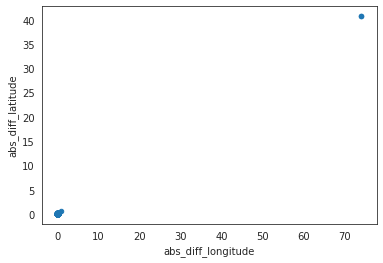

In [8]:
#Plotting the absolute differce to find the distance where the 1 degree difference is equals to 69 miles approximately 
plot = train_df.iloc[:2000].plot.scatter('abs_diff_longitude', 'abs_diff_latitude')

In [9]:
#As the fare is calculated for the trips inside the Newyork city 
#so we will drop the values that exceed the absolute difference more than 5 in test and train data 

print('Old size: %d' % len(train_df))
train_df = train_df[(train_df.abs_diff_longitude < 5.0) & (train_df.abs_diff_latitude < 5.0)]
print('New size: %d' % len(train_df))

print('Old size: %d' % len(test_df))
test_df = test_df[(test_df.abs_diff_longitude < 5.0) & (test_df.abs_diff_latitude < 5.0)]
print('New size: %d' % len(test_df))


Old size: 999990
New size: 998025
Old size: 9914
New size: 9914


In [10]:
#Extracting the pickup time from test and train data 
ls1 = list(train_df['pickup_datetime'])
for i in range(len(ls1)):
    ls1[i] = ls1[i][11:-7:]
train_df['pickup_time'] = ls1

ls1 = list(test_df['pickup_datetime'])
for i in range(len(ls1)):
    ls1[i] = ls1[i][11:-7:]
test_df['pickup_time'] = ls1

In [11]:
#Seggregating the dates as weekday/weekends 
ls1 = list(train_df['pickup_datetime'])
for i in range(len(ls1)):
    ls1[i] = ls1[i][:-4:]
    ls1[i] = pd.Timestamp(ls1[i])
    ls1[i] = ls1[i].weekday()
train_df['Weekday'] = ls1

ls1 = list(test_df['pickup_datetime'])
for i in range(len(ls1)):
    ls1[i] = ls1[i][:-4:]
    ls1[i] = pd.Timestamp(ls1[i])
    ls1[i] = ls1[i].weekday()
test_df['Weekday'] = ls1


train_df.drop('pickup_datetime',inplace=True,axis=1)
test_df.drop('pickup_datetime',inplace=True,axis=1)

train_df['Weekday'].replace(to_replace=[i for i in range(0,7)],value = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],inplace=True)
test_df['Weekday'].replace(to_replace=[i for i in range(0,7)],value = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],inplace=True)

In [12]:
test_df.head()

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,pickup_time,Weekday
0,2015-01-27 13:08:24.0000002,-73.973320,40.763805,-73.981430,40.743835,1,0.008110,0.019970,13:08,Tuesday
1,2015-01-27 13:08:24.0000003,-73.986862,40.719383,-73.998886,40.739201,1,0.012024,0.019817,13:08,Tuesday
2,2011-10-08 11:53:44.0000002,-73.982524,40.751260,-73.979654,40.746139,1,0.002870,0.005121,11:53,Saturday
3,2012-12-01 21:12:12.0000002,-73.981160,40.767807,-73.990448,40.751635,1,0.009288,0.016172,21:12,Saturday
4,2012-12-01 21:12:12.0000003,-73.966046,40.789775,-73.988565,40.744427,1,0.022519,0.045348,21:12,Saturday


In [13]:
train_df.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,pickup_time,Weekday
0,2009-06-15 17:26:21.0000001,4.5,-73.844311,40.721319,-73.841610,40.712278,1,0.002701,0.009041,17:26,Monday
1,2010-01-05 16:52:16.0000002,16.9,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701,16:52,Tuesday
2,2011-08-18 00:35:00.00000049,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708,00:35,Thursday
3,2012-04-21 04:30:42.0000001,7.7,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949,04:30,Saturday
4,2010-03-09 07:51:00.000000135,5.3,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754,07:51,Tuesday


In [14]:
#Extracting the trips from weekdays from test and train data 
train_one_hot = pd.get_dummies(train_df['Weekday'])
test_one_hot = pd.get_dummies(test_df['Weekday'])
train_df = pd.concat([train_df,train_one_hot],axis=1)
test_df = pd.concat([test_df,test_one_hot],axis=1)

In [15]:
test_df.head()

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,pickup_time,Weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,2015-01-27 13:08:24.0000002,-73.973320,40.763805,-73.981430,40.743835,1,0.008110,0.019970,13:08,Tuesday,0,0,0,0,0,1,0
1,2015-01-27 13:08:24.0000003,-73.986862,40.719383,-73.998886,40.739201,1,0.012024,0.019817,13:08,Tuesday,0,0,0,0,0,1,0
2,2011-10-08 11:53:44.0000002,-73.982524,40.751260,-73.979654,40.746139,1,0.002870,0.005121,11:53,Saturday,0,0,1,0,0,0,0
3,2012-12-01 21:12:12.0000002,-73.981160,40.767807,-73.990448,40.751635,1,0.009288,0.016172,21:12,Saturday,0,0,1,0,0,0,0
4,2012-12-01 21:12:12.0000003,-73.966046,40.789775,-73.988565,40.744427,1,0.022519,0.045348,21:12,Saturday,0,0,1,0,0,0,0


In [16]:
train_df.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,pickup_time,Weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,2009-06-15 17:26:21.0000001,4.5,-73.844311,40.721319,-73.841610,40.712278,1,0.002701,0.009041,17:26,Monday,0,1,0,0,0,0,0
1,2010-01-05 16:52:16.0000002,16.9,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701,16:52,Tuesday,0,0,0,0,0,1,0
2,2011-08-18 00:35:00.00000049,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708,00:35,Thursday,0,0,0,0,1,0,0
3,2012-04-21 04:30:42.0000001,7.7,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949,04:30,Saturday,0,0,1,0,0,0,0
4,2010-03-09 07:51:00.000000135,5.3,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754,07:51,Tuesday,0,0,0,0,0,1,0


In [17]:
train_df.drop('Weekday',axis=1,inplace=True)
test_df.drop('Weekday',axis=1,inplace=True)

In [18]:
ls1 = list(train_df['pickup_time'])
for i in range(len(ls1)):
    z = ls1[i].split(':')
    ls1[i] = int(z[0])*100+int(z[1])
train_df['pickup_time'] = ls1

ls1 = list(test_df['pickup_time'])
for i in range(len(ls1)):
    z = ls1[i].split(':')
    ls1[i] = int(z[0])*100+int(z[1])
test_df['pickup_time'] = ls1

In [19]:
train_df.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,pickup_time,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,2009-06-15 17:26:21.0000001,4.5,-73.844311,40.721319,-73.841610,40.712278,1,0.002701,0.009041,1726,0,1,0,0,0,0,0
1,2010-01-05 16:52:16.0000002,16.9,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701,1652,0,0,0,0,0,1,0
2,2011-08-18 00:35:00.00000049,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708,35,0,0,0,0,1,0,0
3,2012-04-21 04:30:42.0000001,7.7,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949,430,0,0,1,0,0,0,0
4,2010-03-09 07:51:00.000000135,5.3,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754,751,0,0,0,0,0,1,0


In [20]:
test_df.head()

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,pickup_time,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,2015-01-27 13:08:24.0000002,-73.973320,40.763805,-73.981430,40.743835,1,0.008110,0.019970,1308,0,0,0,0,0,1,0
1,2015-01-27 13:08:24.0000003,-73.986862,40.719383,-73.998886,40.739201,1,0.012024,0.019817,1308,0,0,0,0,0,1,0
2,2011-10-08 11:53:44.0000002,-73.982524,40.751260,-73.979654,40.746139,1,0.002870,0.005121,1153,0,0,1,0,0,0,0
3,2012-12-01 21:12:12.0000002,-73.981160,40.767807,-73.990448,40.751635,1,0.009288,0.016172,2112,0,0,1,0,0,0,0
4,2012-12-01 21:12:12.0000003,-73.966046,40.789775,-73.988565,40.744427,1,0.022519,0.045348,2112,0,0,1,0,0,0,0


In [21]:
R = 6373.0
lat1 = np.asarray(np.radians(train_df['pickup_latitude']))
lon1 = np.asarray(np.radians(train_df['pickup_longitude']))
lat2 = np.asarray(np.radians(train_df['dropoff_latitude']))
lon2 = np.asarray(np.radians(train_df['dropoff_longitude']))

dlon = lon2-lon1
dlat = lat2-lat1
ls1=[]
a = np.sin(dlat/2)**2 +np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
c = 2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
distance = R*c

train_df['Distance'] = np.asarray(distance)*0.621

lat1 = np.asarray(np.radians(test_df['pickup_latitude']))
lon1 = np.asarray(np.radians(test_df['pickup_longitude']))
lat2 = np.asarray(np.radians(test_df['dropoff_latitude']))
lon2 = np.asarray(np.radians(test_df['dropoff_longitude']))

dlon = lon2-lon1
dlat = lat2-lat1
ls1=[]
a = np.sin(dlat/2)**2 +np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
c = 2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
distance = R*c

test_df['Distance'] = np.asarray(distance)*0.621




In [22]:
R = 6373.0
lat1 = np.asarray(np.radians(train_df['pickup_latitude']))
lon1 = np.asarray(np.radians(train_df['pickup_longitude']))
lat2 = np.asarray(np.radians(train_df['dropoff_latitude']))
lon2 = np.asarray(np.radians(train_df['dropoff_longitude']))

lat3 = np.zeros(len(train_df['pickup_latitude']))+np.radians(40.6413)
lon3 = np.zeros(len(train_df['pickup_longitude']))+np.radians(-73.7781)
dlon_pickup = lon3-lon1
dlat_pickup = lat3-lat1
d_lon_dropoff = lon3-lon2
d_lat_dropoff = lat3-lat2
a1 = np.sin(dlat_pickup/2)**2 +np.cos(lat1)*np.cos(lat3)*np.sin(dlon_pickup/2)**2
c1 = 2*np.arctan2(np.sqrt(a1),np.sqrt(1-a1))
distance1 = R*c1
train_df['Pickup_Distance_airport'] = np.asarray(distance1)*0.621

a2 = np.sin(d_lat_dropoff/2)**2 +np.cos(lat2)*np.cos(lat3)*np.sin(d_lon_dropoff/2)**2
c2 = 2*np.arctan2(np.sqrt(a2),np.sqrt(1-a2))
distance2 = R*c2
train_df['Dropoff_Distance_airport'] = np.asarray(distance2)*0.621

lat1 = np.asarray(np.radians(test_df['pickup_latitude']))
lon1 = np.asarray(np.radians(test_df['pickup_longitude']))
lat2 = np.asarray(np.radians(test_df['dropoff_latitude']))
lon2 = np.asarray(np.radians(test_df['dropoff_longitude']))

lat3 = np.zeros(len(test_df['pickup_latitude']))+np.radians(40.6413)
lon3 = np.zeros(len(test_df['pickup_latitude']))+np.radians(-73.7781)
dlon_pickup = lon3-lon1
dlat_pickup = lat3-lat1
d_lon_dropoff = lon3-lon2
d_lat_dropoff = lat3-lat2
a1 = np.sin(dlat_pickup/2)**2 +np.cos(lat1)*np.cos(lat3)*np.sin(dlon_pickup/2)**2
c1 = 2*np.arctan2(np.sqrt(a1),np.sqrt(1-a1))
distance1 = R*c1
test_df['Pickup_Distance_airport'] = np.asarray(distance1)*0.621

a2 = np.sin(d_lat_dropoff/2)**2 +np.cos(lat2)*np.cos(lat3)*np.sin(d_lon_dropoff/2)**2
c2 = 2*np.arctan2(np.sqrt(a2),np.sqrt(1-a2))
distance2 = R*c2
test_df['Dropoff_Distance_airport'] = np.asarray(distance2)*0.621

In [23]:
train_df['Distance'] = np.round(train_df['Distance'],2)
train_df['Pickup_Distance_airport'] = np.round(train_df['Pickup_Distance_airport'],2)
train_df['Dropoff_Distance_airport'] = np.round(train_df['Dropoff_Distance_airport'],2)
test_df['Distance'] = np.round(test_df['Distance'],2)
test_df['Pickup_Distance_airport'] = np.round(test_df['Pickup_Distance_airport'],2)
test_df['Dropoff_Distance_airport'] = np.round(test_df['Dropoff_Distance_airport'],2)

In [24]:
train_df.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis=1,inplace=True)
test_df.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis=1,inplace=True)

In [27]:
train_df['abs_diff_longitude']=np.abs(train_df['abs_diff_longitude'])-np.mean(train_df['abs_diff_longitude'])
train_df['abs_diff_longitude']=train_df['abs_diff_longitude']/np.var(train_df['abs_diff_longitude'])

In [28]:
train_df['abs_diff_latitude']=np.abs(train_df['abs_diff_latitude'])-np.mean(train_df['abs_diff_latitude'])
train_df['abs_diff_latitude']=train_df['abs_diff_latitude']/np.var(train_df['abs_diff_latitude'])

In [29]:
test_df['abs_diff_longitude']=np.abs(test_df['abs_diff_longitude'])-np.mean(test_df['abs_diff_longitude'])
test_df['abs_diff_longitude']=test_df['abs_diff_longitude']/np.var(test_df['abs_diff_longitude'])

In [30]:
test_df['abs_diff_latitude']=np.abs(test_df['abs_diff_latitude'])-np.mean(test_df['abs_diff_latitude'])
test_df['abs_diff_latitude']=test_df['abs_diff_latitude']/np.var(test_df['abs_diff_latitude'])

In [31]:
train_df.shape

(998025, 16)

In [32]:
test_df.shape

(9914, 15)

In [33]:
train_df.head()

,key,fare_amount,passenger_count,abs_diff_longitude,abs_diff_latitude,pickup_time,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Distance,Pickup_Distance_airport,Dropoff_Distance_airport
0,2009-06-15 17:26:21.0000001,4.5,1,0.026636,0.017893,1726,0,1,0,0,0,0,0,0.64,6.53,5.92
1,2010-01-05 16:52:16.0000002,16.9,1,0.019198,0.073711,1652,0,0,0,0,0,1,0,5.25,13.37,14.33
2,2011-08-18 00:35:00.00000049,5.7,2,0.018832,0.015416,35,0,0,0,0,1,0,0,0.86,13.55,13.47
3,2012-04-21 04:30:42.0000001,7.7,1,0.024302,0.005740,430,0,0,1,0,0,0,0,1.74,12.65,13.79
4,2010-03-09 07:51:00.000000135,5.3,1,0.014883,0.007920,751,0,0,0,0,0,1,0,1.24,13.25,13.57


In [34]:

X = train_df.drop(['key','fare_amount'],axis=1)
y = train_df['fare_amount']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.01,random_state=80)

In [35]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(normalize=True)
lr.fit(X_train,y_train)
print(lr.score(X_test,y_test))

0.5069131759043988


In [36]:
pred = np.round(lr.predict(test_df.drop('key',axis=1)),2)

In [37]:
train_df.head()

,key,fare_amount,passenger_count,abs_diff_longitude,abs_diff_latitude,pickup_time,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Distance,Pickup_Distance_airport,Dropoff_Distance_airport
0,2009-06-15 17:26:21.0000001,4.5,1,0.026636,0.017893,1726,0,1,0,0,0,0,0,0.64,6.53,5.92
1,2010-01-05 16:52:16.0000002,16.9,1,0.019198,0.073711,1652,0,0,0,0,0,1,0,5.25,13.37,14.33
2,2011-08-18 00:35:00.00000049,5.7,2,0.018832,0.015416,35,0,0,0,0,1,0,0,0.86,13.55,13.47
3,2012-04-21 04:30:42.0000001,7.7,1,0.024302,0.005740,430,0,0,1,0,0,0,0,1.74,12.65,13.79
4,2010-03-09 07:51:00.000000135,5.3,1,0.014883,0.007920,751,0,0,0,0,0,1,0,1.24,13.25,13.57


In [38]:
output = pd.DataFrame(data=pred,columns=['fare_amount'])
output['key'] = test_df['key']
output = output[['key','fare_amount']]

In [39]:
output.set_index('key',inplace=True)

In [41]:
#Saving the Predections for Simple Linear Regression Model 
output.to_csv('/content/drive/MyDrive/DM_DATASET/simple_linear_model_output.csv')

# **Random Forest Model**

In [125]:
def rmse(y_true, y_pred):
    return np.sqrt(np.sum((y_true - y_pred) ** 2) / y_true.size)

def mae (y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [126]:
lon_min, lon_max = -75, -72
lat_min, lat_max = 40, 43

In [127]:
n_min, lon_max = -75, -72
lat_min, lat_max = 40, 43

df = pd.read_csv("/content/drive/MyDrive/DM_DATASET/train.csv", nrows = 1000000)

df = df.drop(columns=["key"])

df["date"] = df["pickup_datetime"].apply(lambda x: x.split()[0])
df["time"] = df["pickup_datetime"].apply(lambda x: x.split()[1])
df = df.drop("pickup_datetime", axis=1)

df["year"] = df["date"].apply(lambda x: int(x.split("-")[0]))
df["month"] = df["date"].apply(lambda x: int(x.split("-")[1]))
df["day"] = df["date"].apply(lambda x: int(x.split("-")[2]))
df = df.drop("date", axis=1)
df["time"] = df["time"].apply(lambda x: int(x[:2]) * 60 + int(x[3:5]))

df["befor_shock"] = ((df["year"] <= 2011) | ((df["year"] <= 2012) & (df["month"] <= 8))).apply(int)

df = df[
    (~df["dropoff_longitude"].isnull()) &
    (~df["dropoff_latitude"].isnull())
]

df = df[
    (lon_min < df["pickup_longitude"]) &
    (df["pickup_longitude"] < lon_max) &
    (lat_min < df["pickup_latitude"]) &
    (df["pickup_latitude"] < lat_max) &

    (lon_min < df["dropoff_longitude"]) &
    (df["dropoff_longitude"] < lon_max) &
    (lat_min < df["dropoff_latitude"]) &
    (df["dropoff_latitude"] < lat_max)
]

df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,time,year,month,day,befor_shock
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,1046,2009,6,15,1
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,1012,2010,1,5,1
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,35,2011,8,18,1
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,270,2012,4,21,1
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,471,2010,3,9,1


In [128]:
X = np.array(df.drop(
    columns=[
        "fare_amount",
    ]
))
y = np.array(df["fare_amount"])

In [129]:
np.random.seed(seed=1234)

train_rows = np.random.rand(y.size) > 0.2

X_train, y_train = X[train_rows, :], y[train_rows]
X_valid, y_valid = X[~train_rows, :], y[~train_rows]

In [130]:
model = RandomForestRegressor(max_depth=30, n_estimators=100, n_jobs=-1)

model.fit(X_train, y_train)

y_valid_pred = model.predict(X_valid)

print("RMSE Value: ",rmse(y_valid, y_valid_pred))
print("MAE Value: ", np.mean(mae(y_valid, y_valid_pred)))


RMSE Value:  3.9717755111917263
MAE Value:  1.7797291414097816


In [131]:
test = pd.read_csv('/content/drive/MyDrive/DM_DATASET/test.csv')

test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [132]:
test["date"] = test["pickup_datetime"].apply(lambda x: x.split()[0])
test["time"] = test["pickup_datetime"].apply(lambda x: x.split()[1])
test = test.drop("pickup_datetime", axis=1)

test["year"] = test["date"].apply(lambda x: int(x.split("-")[0]))
test["month"] = test["date"].apply(lambda x: int(x.split("-")[1]))
test["day"] = test["date"].apply(lambda x: int(x.split("-")[2]))
test = test.drop("date", axis=1)
test["time"] = test["time"].apply(lambda x: int(x[:2]) * 60 + int(x[3:5]))

test["before_shock"] = ((test["year"] <= 2011) | ((test["year"] <= 2012) & (test["month"] <= 8))).apply(int)


test.head()

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,time,year,month,day,before_shock
0,2015-01-27 13:08:24.0000002,-73.973320,40.763805,-73.981430,40.743835,1,788,2015,1,27,0
1,2015-01-27 13:08:24.0000003,-73.986862,40.719383,-73.998886,40.739201,1,788,2015,1,27,0
2,2011-10-08 11:53:44.0000002,-73.982524,40.751260,-73.979654,40.746139,1,713,2011,10,8,1
3,2012-12-01 21:12:12.0000002,-73.981160,40.767807,-73.990448,40.751635,1,1272,2012,12,1,0
4,2012-12-01 21:12:12.0000003,-73.966046,40.789775,-73.988565,40.744427,1,1272,2012,12,1,0


In [133]:
X_test = np.array(test.drop(columns=[
    "key",
]))
y_pred = model.predict(X_test)
test["fare_amount"] = y_pred
output= test[["key", "fare_amount"]]

output.to_csv("/content/drive/MyDrive/DM_DATASET/randomforest_out.csv", index=False)

# **XGBoost Model**

In [97]:
data = pd.read_csv("/content/drive/MyDrive/DM_DATASET/train.csv", nrows = 1000000)
print("Dataset Dimensions: ", data.shape)
data.dtypes

Dataset Dimensions:  (1000000, 8)


key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [98]:
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


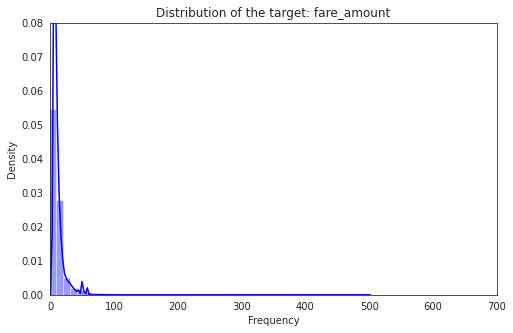

In [99]:
f, ax = plt.subplots(1, 1, figsize=(8,5))
sns.distplot(data["fare_amount"], kde=True, color="blue")
plt.xlim(0, 700)
plt.ylim(0, 0.08)
plt.title("Distribution of the target: fare_amount")
plt.xlabel("Frequency")
plt.show()

In [100]:
q1  = data['fare_amount'].quantile(0.25)
q3  = data['fare_amount'].quantile(0.75)
iqr =  q3 - q1
print("Fare Amount lower bound : ", q1 - (1.5 * iqr), 
      "Fare Amount upper bound : ", q3 + (1.5 * iqr))

Fare Amount lower bound :  -3.75 Fare Amount upper bound :  22.25


In [101]:
print("Total null values:", data.isnull().sum())
print("Percentage of null values:",
      data[["dropoff_longitude", "dropoff_latitude"]].isnull().sum() / data.shape[0])

Total null values: key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    10
dropoff_latitude     10
passenger_count       0
dtype: int64
Percentage of null values: dropoff_longitude    0.00001
dropoff_latitude     0.00001
dtype: float64


In [102]:
data.dropna(how='any', axis='rows', inplace=True)

In [103]:
data.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

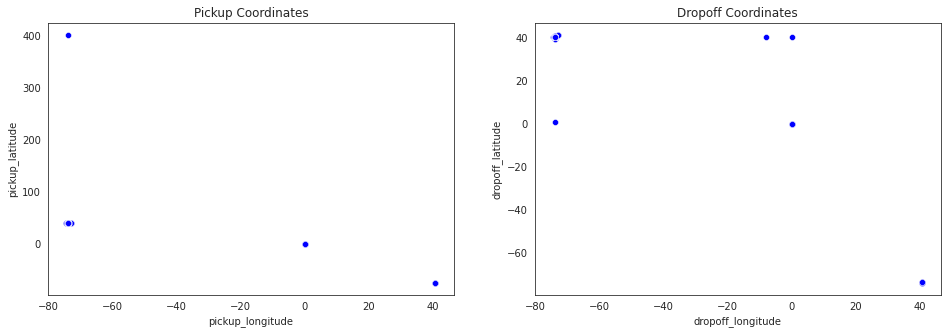

In [104]:
f, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.scatterplot(x="pickup_longitude", y="pickup_latitude", data=data.iloc[:10000], 
                color="blue", ax=ax[0])
sns.scatterplot(x="dropoff_longitude", y="dropoff_latitude", data=data.iloc[:10000], 
                color="blue", ax=ax[1])
ax[0].set_title("Pickup Coordinates")
ax[1].set_title("Dropoff Coordinates")
plt.show()

In [105]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000
mean,11.347953,-72.526699,39.929040,-72.527860,39.919954,1.684941
std,9.821790,12.057778,7.626087,11.324494,8.201418,1.323907
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000


In [106]:
def get_cleaned(df):
    return df[(df.fare_amount > 0) &
              (df.pickup_latitude > 35) & (df.pickup_latitude < 45) &
              (df.pickup_longitude > -80) & (df.pickup_longitude < -68) &
              (df.dropoff_latitude > 35) & (df.dropoff_latitude < 45) &
              (df.pickup_longitude > -80) & (df.dropoff_longitude < -68) &
              (df.passenger_count > 0) & (df.passenger_count < 8)]

data = get_cleaned(data)
print(len(data))
print("Data lost after the cleaning process: ", 1000000 - len(data))

975974
Data lost after the cleaning process:  24026


In [107]:
def sphere_dist(pick_lat, pick_lon, drop_lat, drop_lon):
    R_earth = 6371 # Earth radius (in km)
    # Convert degrees to radians
    pick_lat, pick_lon, drop_lat, drop_lon = map(np.radians, [pick_lat, pick_lon,
                                                              drop_lat, drop_lon])
    # Compute distances along lat, lon dimensions
    dlat = drop_lat - pick_lat
    dlon = drop_lon - pick_lon
    
    # Compute haversine distance
    a = np.sin(dlat/2.0)**2 + np.cos(pick_lat) * np.cos(drop_lat) * np.sin(dlon/2.0)**2
    return 2 * R_earth * np.arcsin(np.sqrt(a))

In [108]:
def airport_dist(df):
    """
    JFK: John F. Kennedy International Airport
    EWR: Newark Liberty International Airport
    LGA: LaGuardia Airport
    """
    jfk_coord = (40.639722, -73.778889)
    ewr_coord = (40.6925, -74.168611)
    lga_coord = (40.77725, -73.872611)
    
    pick_lat = df['pickup_latitude']
    pick_lon = df['pickup_longitude']
    drop_lat = df['dropoff_latitude']
    drop_lon = df['dropoff_longitude']
    
    pickup_jfk = sphere_dist(pick_lat, pick_lon, jfk_coord[0], jfk_coord[1])
    dropoff_jfk = sphere_dist(jfk_coord[0], jfk_coord[1], drop_lat, drop_lon) 
    pickup_ewr = sphere_dist(pick_lat, pick_lon, ewr_coord[0], ewr_coord[1])
    dropoff_ewr = sphere_dist(ewr_coord[0], ewr_coord[1], drop_lat, drop_lon) 
    pickup_lga = sphere_dist(pick_lat, pick_lon, lga_coord[0], lga_coord[1]) 
    dropoff_lga = sphere_dist(lga_coord[0], lga_coord[1], drop_lat, drop_lon)
    
    df['jfk_dist'] = pd.concat([pickup_jfk, dropoff_jfk], axis=1).min(axis=1)
    df['ewr_dist'] = pd.concat([pickup_ewr, dropoff_ewr], axis=1).min(axis=1)
    df['lga_dist'] = pd.concat([pickup_lga, dropoff_lga], axis=1).min(axis=1)
    
    return df

In [109]:
def datetime_info(df):
    #Convert to datetime format
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'],format="%Y-%m-%d %H:%M:%S UTC")
    
    df['hour'] = df.pickup_datetime.dt.hour
    df['day'] = df.pickup_datetime.dt.day
    df['month'] = df.pickup_datetime.dt.month
    df['weekday'] = df.pickup_datetime.dt.weekday
    df['year'] = df.pickup_datetime.dt.year
    
    return df


data = datetime_info(data)
data = airport_dist(data)
data['distance'] = sphere_dist(data['pickup_latitude'], data['pickup_longitude'], 
                               data['dropoff_latitude'], data['dropoff_longitude'])

data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,jfk_dist,ewr_dist,lga_dist,distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,17,15,6,0,2009,9.647141,27.523051,6.660494,1.030764
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,1,2010,21.525635,13.029641,8.996046,8.450134
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0,18,8,3,2011,21.735040,16.282199,9.442812,1.389525
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,4,21,4,5,2012,20.401167,15.949684,10.241872,2.799270
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,7,9,3,1,2010,21.397709,18.867107,7.113348,1.999157


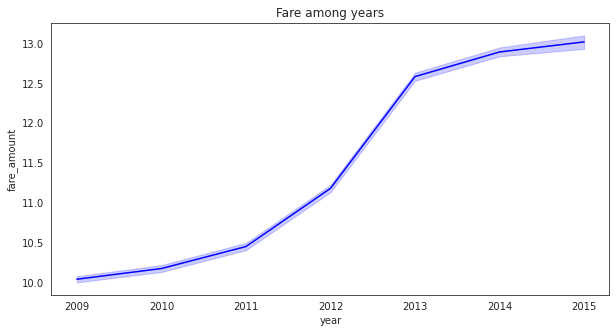

In [110]:
plt.figure(figsize=(10,5))
sns.lineplot(x="year", y="fare_amount", data=data, color="blue")
plt.title("Fare among years")
plt.show()

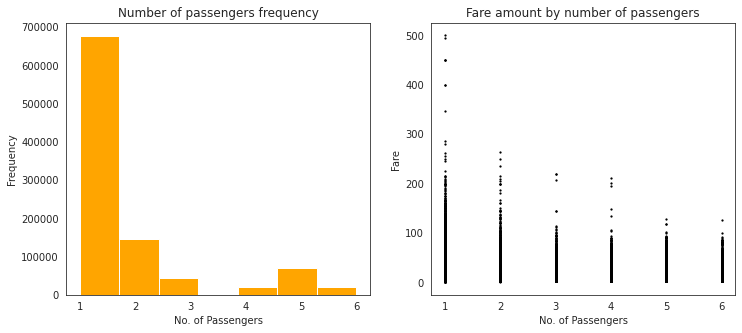

In [111]:
f, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].hist(data["passenger_count"], bins=7, color=("orange"))
ax[0].set_title("Number of passengers frequency")
ax[0].set_xlabel('No. of Passengers')
ax[0].set_ylabel('Frequency')

ax[1].scatter(x=data["passenger_count"], y=data["fare_amount"], s=1.5, 
              color=("black"))
ax[1].set_title("Fare amount by number of passengers")
ax[1].set_xlabel('No. of Passengers')
ax[1].set_ylabel('Fare');

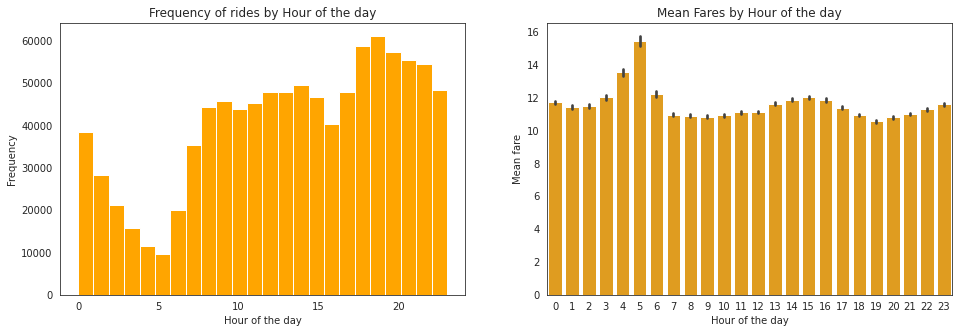

In [112]:
f, ax = plt.subplots(1, 2, figsize=(16,5))
ax[0].hist(data["hour"], bins=24, color="orange")
ax[0].set_title("Frequency of rides by Hour of the day")
ax[0].set_xlabel('Hour of the day')
ax[0].set_ylabel('Frequency')

#ax[1].scatter(x=data["hour"], y=data["fare_amount"], s=1.5, c="black")
#ax[1].set_title("Fares by Hour of the day")
#ax[1].set_xlabel('Hour of the day')
#ax[1].set_ylabel('Fare')

sns.barplot(x="hour", y="fare_amount", data=data, ax=ax[1], color="orange")
ax[1].set_title("Mean Fares by Hour of the day")
ax[1].set_xlabel('Hour of the day')
ax[1].set_ylabel('Mean fare')
plt.show()

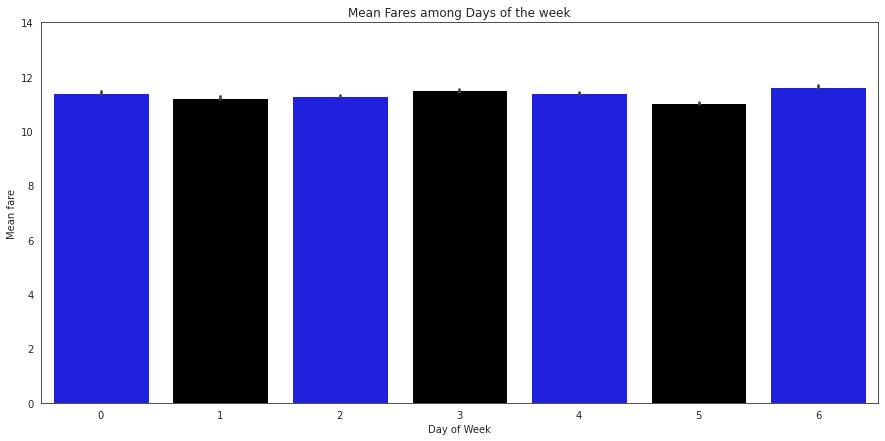

In [113]:
plt.figure(figsize=(15,7))
sns.barplot(x='weekday', y="fare_amount", data=data, palette=("blue", "black"))
plt.ylim(0, 14)
plt.title("Mean Fares among Days of the week")
plt.xlabel('Day of Week')
plt.ylabel('Mean fare')
plt.show()

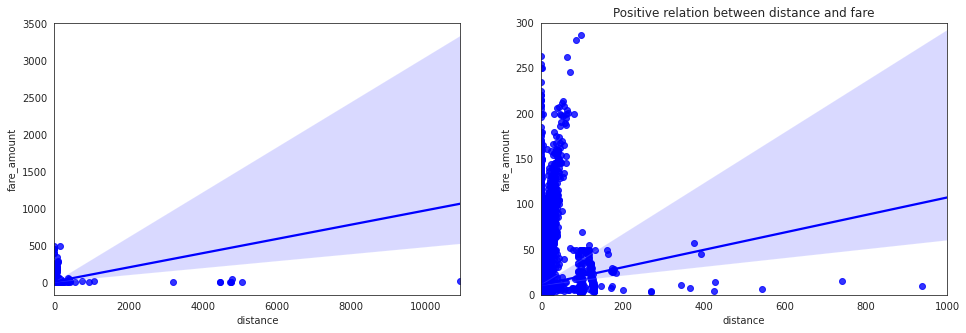

In [114]:
f, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.regplot(x="distance", y="fare_amount", data=data, color="blue", ax=ax[0])
sns.regplot(x="distance", y="fare_amount", data=data, color="blue", ax=ax[1])
ax[1].set_xlim(0, 1000)
ax[1].set_ylim(0, 300)
plt.title("Positive relation between distance and fare")
plt.show()

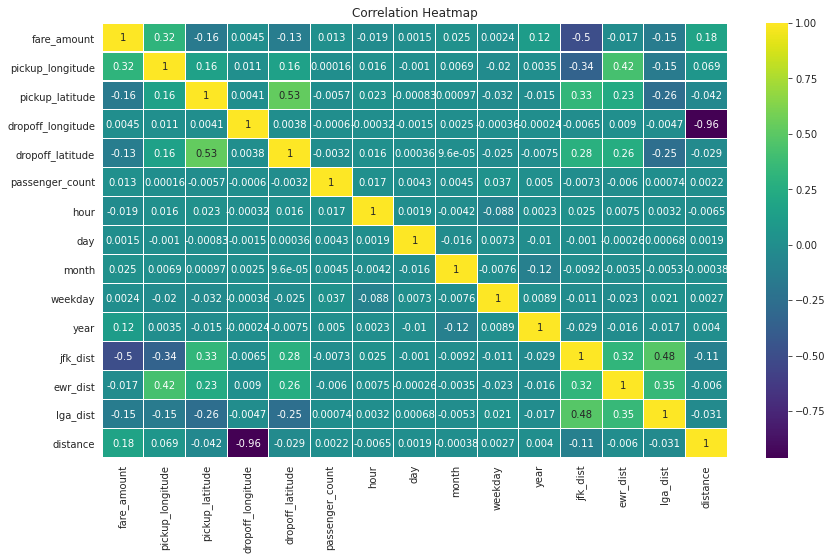

In [115]:
f = plt.figure(figsize=(14, 8))
sns.heatmap(data.corr(), annot=True, linewidths=0.2, cmap="viridis")
plt.title("Correlation Heatmap")
plt.show()

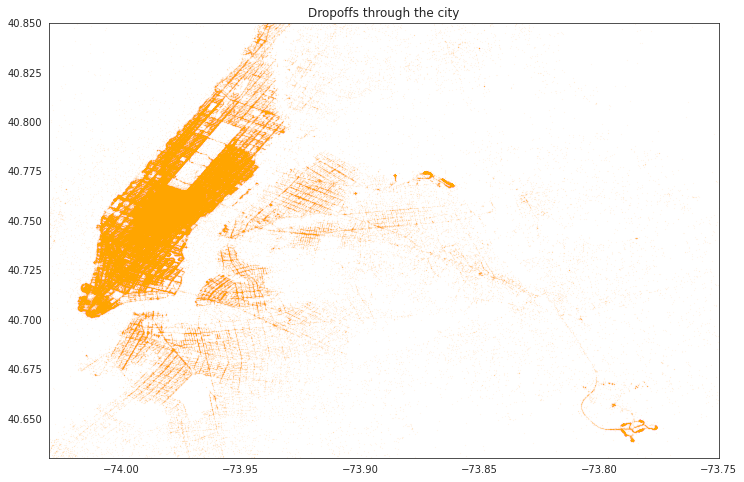

In [116]:
dropoff_longitude = data['dropoff_longitude'].to_numpy()
dropoff_latitude = data['dropoff_latitude'].to_numpy()

plt.figure(figsize=(12,8))
plt.scatter(dropoff_longitude, dropoff_latitude,
                color="orange", 
                s=.02, alpha=.2)
plt.title("Dropoffs through the city")
# Borders of the city
plt.xlim(-74.03, -73.75)
plt.ylim(40.63, 40.85)
plt.show()

In [117]:
data.drop(columns=["key", "pickup_datetime"], inplace=True)
data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,jfk_dist,ewr_dist,lga_dist,distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,17,15,6,0,2009,9.647141,27.523051,6.660494,1.030764
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,1,2010,21.525635,13.029641,8.996046,8.450134
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0,18,8,3,2011,21.735040,16.282199,9.442812,1.389525
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,4,21,4,5,2012,20.401167,15.949684,10.241872,2.799270
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,7,9,3,1,2010,21.397709,18.867107,7.113348,1.999157


In [118]:
y = data["fare_amount"]
train = data.drop(columns=["fare_amount"])

x_train, x_test, y_train, y_test = train_test_split(train, y, random_state=2666, test_size=0.05)

In [119]:
params = {
    "max_depth": 7,
    "subsample": 0.9,
    "eta": 0.03,
    "colsample_bytree": 0.9,
    "random_state": 2666,
    "objective": "reg:linear",
    "eval_metric": "mae",
    "silent": 1
}

In [120]:
def XGBmodel(x_train, x_test, y_train, y_test, params):
    matrix_train = xgb.DMatrix(x_train, label=y_train)
    matrix_test = xgb.DMatrix(x_test, label=y_test)
    model = xgb.train(params=params,
                      dtrain=matrix_train,num_boost_round=5000, 
                      early_stopping_rounds=10,evals=[(matrix_test,'test')])
    return model

start_time = time.time()
model = XGBmodel(x_train, x_test, y_train, y_test, params)

[0]	test-mae:10.4951
Will train until test-mae hasn't improved in 10 rounds.
[1]	test-mae:10.182
[2]	test-mae:9.87795
[3]	test-mae:9.58334
[4]	test-mae:9.2974
[5]	test-mae:9.02087
[6]	test-mae:8.7522
[7]	test-mae:8.4933
[8]	test-mae:8.24271
[9]	test-mae:8.00014
[10]	test-mae:7.76537
[11]	test-mae:7.53784
[12]	test-mae:7.31771
[13]	test-mae:7.1046
[14]	test-mae:6.89737
[15]	test-mae:6.69726
[16]	test-mae:6.50336
[17]	test-mae:6.31557
[18]	test-mae:6.13389
[19]	test-mae:5.95766
[20]	test-mae:5.78685
[21]	test-mae:5.6211
[22]	test-mae:5.46121
[23]	test-mae:5.30637
[24]	test-mae:5.15657
[25]	test-mae:5.01125
[26]	test-mae:4.87172
[27]	test-mae:4.73631
[28]	test-mae:4.60689
[29]	test-mae:4.48065
[30]	test-mae:4.36062
[31]	test-mae:4.24519
[32]	test-mae:4.13209
[33]	test-mae:4.02281
[34]	test-mae:3.91759
[35]	test-mae:3.81656
[36]	test-mae:3.71914
[37]	test-mae:3.62955
[38]	test-mae:3.54399
[39]	test-mae:3.45822
[40]	test-mae:3.37569
[41]	test-mae:3.29678
[42]	test-mae:3.22102
[43]	test-mae:

In [121]:
time_taken = time.time() - start_time
time_taken

2152.4643058776855

In [123]:
test =  pd.read_csv('/content/drive/MyDrive/DM_DATASET/test.csv')
test = datetime_info(test)
test = airport_dist(test)
test['distance'] = sphere_dist(test['pickup_latitude'], test['pickup_longitude'], 
                               test['dropoff_latitude'] , test['dropoff_longitude'])
test_key = test['key']
x_pred = test.drop(columns=['key', 'pickup_datetime']) 

#Predict from test set
prediction = model.predict(xgb.DMatrix(x_pred), ntree_limit=model.best_ntree_limit)

In [124]:
#Create output file
output = pd.DataFrame({
        "key": test_key,
        "fare_amount": prediction.round(2)
})

output.to_csv('/content/drive/MyDrive/DM_DATASET/XGBoostoutput.csv',index=False)
output.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.510000
1,2015-01-27 13:08:24.0000003,11.080000
2,2011-10-08 11:53:44.0000002,4.800000
3,2012-12-01 21:12:12.0000002,8.900000
4,2012-12-01 21:12:12.0000003,16.030001
